# <center> **A/B-testing**

**Description**  
The company plans to launch a new promotion to sell as many tours as possible. The team developed two versions of the landing page of the company's official website and conducted A/B testing. As a result of the experiment, data were collected.  

**Task**  
Business task: to analyze the effectiveness of both variants of the landing page by two criteria at once: purchase conversion and average check. Based on the analysis, it is necessary to draw conclusions and make a decision: which of the design options is more preferable.

**About data:**  
- user_id - user id-number
- group	- A/B-testing hroup (A-contol, B-test)
- purchase - whether the user made a purchase of the tour (1 - yes, 0 - no)
- price - the price of the purchased tour (if the purchase did not take place, the price is 0)

The company offers the following tour options:
- Thailand - 100,000 rubles;
- Turkey - 60,000 rubles;
- Maldives - 200,000 rubles;
- St. Petersburg - 10,000 rubles;
- Kamchatka - 150,000 rubles.

In [1]:
# load all required libraries
import pandas as pd

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

### **Task 1.**   
Load and explore data

In [5]:
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


### **Task 2**  
Transform the date column to datetime . Make sure that the duration of testing is equal for each of the groups.

In [7]:
# transform to datetime
data['date'] = pd.to_datetime(data['date'])

# check the duration
data.groupby('group')['date'].agg(['min', 'max']).reset_index()

,group,min,max
0,A,2021-01-02,2021-01-24
1,B,2021-01-02,2021-01-24


### **Task 3**
Calculate the number of visits, purchases and the sum of all purchases for both groups.

In [8]:
# group our dateset
data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index()

,group,user_id,purchase,price
0,A,147202,17723,1436260000
1,B,147276,17514,1554100000


### **Task 4**
Check if there are users who were in both test groups during the A / B test? Get rid of it.


In [9]:
# create sets for both groups
data_a = data[data['group'] == 'A']
data_b = data[data['group'] == 'B']
set_a = set(data_a['user_id'])
set_b = set(data_b['user_id'])

# intersect these sets
common_id = set_a.intersection(set_b)

# print the number of people with common id in both groups
print(len(common_id))

# get rid of it
data = data[data['user_id'].apply(lambda x: x not in common_id)]

# check dimensity
data.shape

1895


(290688, 5)

### **Task 5**
Get the following table:
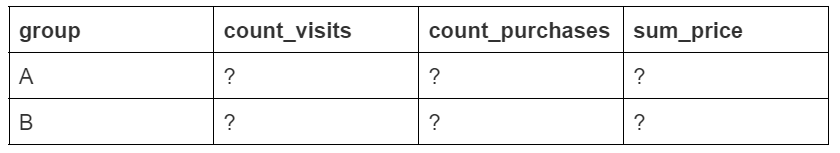
In order to obtain such a table, group the data according to the group. Calculate the following for each group:
- number of visits (number of users);
- the number of purchases made;
- the sum of all purchases in the group.
Rename the columns to count_visits, count_purchases, and sum_price.


In [10]:
# create new dataset for future work
ab_data = data.groupby('group').agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum' 
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase': 'count_purchases',
    'price': 'sum_price'
})

# display it
ab_data

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


**Conclusion**    
The sample size was reduced in both groups by the number of "doubled" visitors, that is, those who fell into both groups.  
The sizes of the groups are as close as possible to each other, so the samples are quite balanced.

### **Task 6**
Add conversion columns to the grouped table:
- purchase conversion (the ratio of the number of purchases to the number of site visits in each group, expressed as a percentage)

In [11]:
# create new feature - conversion purchase
ab_data['conversion'] = ab_data['count_purchases'] / ab_data['count_visits'] * 100
round(ab_data[['group','conversion']], 2)

,group,conversion
0,A,12.03
1,B,11.89


- mean_check — average check (the ratio of the amount of purchases to the number of purchases in each group).

In [12]:
ab_data['mean_check'] = ab_data['sum_price'] / ab_data['count_purchases']
round(ab_data[['group', 'mean_check']])

,group,mean_check
0,A,81076.0
1,B,88665.0


**Сonclusion**  
The conversion in the control group turned out to be slightly higher, but the average check is noticeably lower than in the test group.  
However, it is too early to draw full conclusions.

### **Task 6**
Now let's compare the options for the purchasing power of tours. To do this, build a pivot table that will show the dependence of the number of sales on the group and the price of the tour.  
Visualize the resulting pivot table with an annotated heatmap.

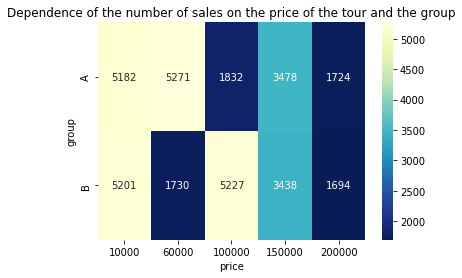

In [13]:
# build a pivot table
purchased_tour = data[data['price'] > 0].pivot_table(
    values='purchase',
    index='group',
    columns='price',
    aggfunc='count'
)

purchase_heatmap = sns.heatmap(purchased_tour, annot=True, fmt='.0f', cmap='YlGnBu_r')
purchase_heatmap.set_title('Dependence of the number of sales on the price of the tour and the group');

**Concluion**   
The difference in purchasing power between the control and the test group is clearly noticeable only in the Turks to Turkey (60k) and Thailand (100k), in other cases the difference is insignificant.  
At the same time, in group B they chose a tour to Thailand much more often, and in group A to Turkey. Probably, this is the reason for the difference in the average check in favor of the test group.

### **Task 8**  
Group the data by date and testing group. In each group, calculate the number of page visits, the number of purchases, and the amount of purchases.   
Add information about the daily conversion (daily number of purchases / daily number of visits) in the group and the daily average check (daily amount of purchases / daily number of purchases) to the table.

In [14]:
# group data according to the task conditions
date_group_df = data.groupby(['date', 'group']).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits',
    'purchase': 'purchases',
    'price': 'income'
})

# создаем столбец ежедневной конверсии
date_group_df['conversion'] = date_group_df['purchases'] / date_group_df['visits'] * 100

# создаем столбец ежедневного среднего чека
date_group_df['average_bill'] = date_group_df['income'] / date_group_df['purchases']

### **Task 9** 
Add cumulative signs to the table with daily indicators:
- cumulative number of page visits;
- cumulative number of purchases;
- the cumulative amount of purchases.  

Calculate the cumulative conversion and the cumulative average check based on the obtained cumulative indicators.  
Plot cumulative conversion and average check graphs in each group by day.

In [15]:
# copy dataset
accum_data = date_group_df.copy()

# create new features
accum_data['cum_visits'] = accum_data.groupby('group')['visits'].cumsum()
accum_data['cum_purchases'] = accum_data.groupby('group')['purchases'].cumsum()
accum_data['cum_income'] = accum_data.groupby('group')['income'].cumsum()

In [16]:
# create new feature for cumulative conversion
accum_data['accum_conversion'] = accum_data['cum_purchases'] / accum_data['cum_visits'] * 100

# create new feature for cumulative average bill
accum_data['accum_average_bill'] = accum_data['cum_income'] / accum_data['cum_purchases']

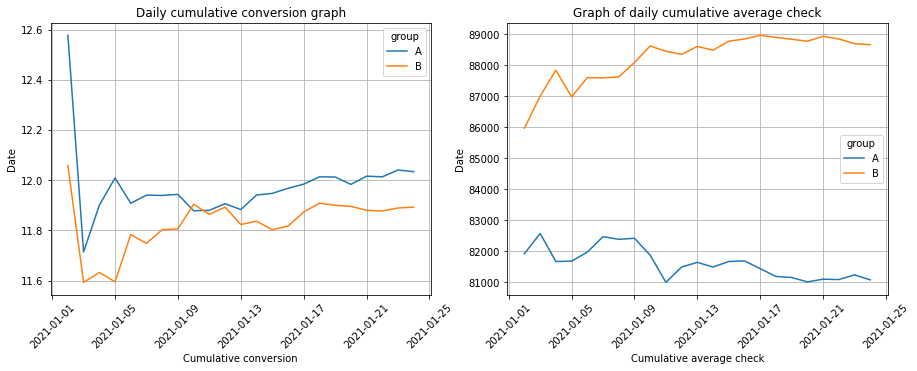

In [17]:
# build a graph
fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.lineplot(data=accum_data, x='date', y='accum_conversion', hue='group', ax=ax[0])
ax[0].set_title('Daily cumulative conversion graph')
ax[0].grid(True)
ax[0].xaxis.set_tick_params(rotation=45)
ax[0].set_xlabel('Cumulative conversion')
ax[0].set_ylabel('Date');

sns.lineplot(data=accum_data, x='date', y='accum_average_bill', hue='group', ax=ax[1])
ax[1].set_title('Graph of daily cumulative average check')
ax[1].grid(True)
ax[1].xaxis.set_tick_params(rotation=45)
ax[1].set_xlabel('Cumulative average check')
ax[1].set_ylabel('Date');

**Conclusion**  
As of January 13 and beyond, both charts have stabilized. The conversion of group A is somewhat higher, but the superiority of the average check in group B is much more noticeable.  
The duration of the observation was sufficient to judge the statistical significance of such a difference in both indicators.

### **Task 10**
It is time to move on to testing the statistical significance of the difference between the metrics in the groups. Let's start with conversion.  
Test under the following null and alternative hypotheses:
- Ho: Conversions in groups A and B are equal;
- Ha: The conversion in group A is greater than the conversion in group B.

In [18]:
# group data
converted_data = data.groupby('group')['purchase'].agg(['count', 'sum'])

# define hypothesis
Ho = 'Conversions in groups A and B are equal.'
Ha = 'The conversion in group A is greater than the conversion in group B.'

# define the significance level
alpha = 0.05

# calculate p-value
_, p_value = proportions_ztest(
    count = converted_data['sum'],
    nobs = converted_data['count'],
    alternative='larger'
)

print('p-value:', round(p_value, 2))

if (p_value < alpha):
    print('We accept the alternative hypothesis.', Ha)
else:
    print('We accept the null hypothesis.', Ho)

p-value: 0.12
We accept the null hypothesis. Conversions in groups A and B are equal.


**Conclusion**    
The true values of conversions in the groups are equal at a significance level of 5%, which means that the difference obtained in previous studies is not statistically significant.
When the significance level is increased by more than 12% (which is rather strange), the conversion in the control group will still be higher. However, in our situation it is important that the conversion of the experimental group B is not higher than the control group.

### **Task 11**
Verify your reasoning by plotting a 95% confidence interval for conversions and the difference between them.

In [19]:
def proportions_conf_interval(n, x_p, gamma=0.95):
    """func for defining a confidence interval

    Args:
        n (int): dimensity of data
        x_p (int): sample proportion
        gamma (float, optional): reliability level. Defaults to 0.95.

    Returns:
        tuple: confidence interval
    """
    
    # find the significance level
    alpha = 1 - gamma
    
    # calculation formulas
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    
    # find the lower bound
    lower_bound = x_p - eps
    
    # find the upper bound
    upper_bound = x_p + eps
    
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


# splitting into 2 table depending on a group
a_data = data[data['group'] == 'A']
b_data = data[data['group'] == 'B']

# caltucalte conversion confidence interval for group A
conf_interval_a = proportions_conf_interval(
    n=a_data['user_id'].count(),
    x_p=a_data['purchase'].mean()
)
# calculate conversion confidence interval for group B
conf_interval_b = proportions_conf_interval(
    n=b_data['user_id'].count(),
    x_p=b_data['purchase'].mean()
)

# display resalts
print('Conversion confidence interval for group A:', conf_interval_a)
print('Conversion confidence interval for group B:', conf_interval_b)

Conversion confidence interval for group A: (11.87, 12.2)
Conversion confidence interval for group B: (11.73, 12.06)


In [20]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    """func for determining the confidence interval of the difference in proportions

    Args:
        n (list): dimensiry if both samples
        xp (list): sample proportions
        gamma (float, optional): reliability level. Defaults to 0.95.

    Returns:
        tuple: the confidence interval of the difference in proportions
    """
    
    # find the significance level
    alpha = 1 - gamma 
    
    # calculation formulas
    diff = xp[1] - xp[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5
    
    # find the lower bound
    lower_bound = diff - eps
    
    # find the upper bound
    upper_bound = diff + eps
    
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# calculate the confidence interval of the difference in proportions
conversion_diff_interval = diff_proportions_conf_interval(
    n = [a_data['user_id'].count(), b_data['user_id'].count()],
    xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
)
print('The conversion confidence interval of the difference in proportions', conversion_diff_interval)

The conversion confidence interval of the difference in proportions (-0.38, 0.09)


**Conclusion**  
The constructed confidence interval with 95% reliability tells us that the difference in conversion between option B and option A lies in the range from -0.38% to 0.09%. This means that there was no statistical difference in conversion between the control and experimental groups, i.e. they are equivalent in terms of conversion metrics.

### **Task 12**  
Test the hypothesis about the normal distribution of the daily average check in each of the testing groups.  

In [21]:
# split dataset with daily values into 2 samples depending on group
stat_a = date_group_df[date_group_df['group'] == 'A']
stat_b = date_group_df[date_group_df['group'] == 'B']

# define hypothesis
Ho = 'The distribution is normal in both groups'
Ha = 'Distribution in one or both groups is not normal'

# define the significance level
alpha = 0.05

# will use the Shapiro-Wilk test
# calculate results for borh samples
shapiro_result_a = shapiro(stat_a['average_bill'])
shapiro_result_b = shapiro(stat_b['average_bill'])

# display p-values for both samples
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы В', round(shapiro_result_b.pvalue, 2))

# display results of test
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print('We accept the alternative hypothesis. {}'.format(Ha))
    
else:
    print('We accept the null hypothesis. {}'.format(Ho))

p-value группы А 0.25
p-value группы В 0.09
We accept the null hypothesis. The distribution is normal in both groups


### **Task 13**
Compare page design options by average check metric.

In [22]:
# define the null and left-sided alternative hypothesis
Ho = 'Daily average checks in groups A and B are equal.'
Ha = 'The daily average check in group A is less than in group B.'

# define the significance level
aplha = 0.05

# use last grouped data
# calculating p-value
results = ttest_ind(
    a=stat_a['average_bill'],
    b=stat_b['average_bill'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

# display resalts
if results.pvalue < alpha:
    print('We accept the alternative hypothesis.', Ha)
else:
    print('We accept the null hypothesis.', Ho)

p-value: 0.0
We accept the alternative hypothesis. The daily average check in group A is less than in group B.


**Conclusion**    
Judging by the conducted statistical tests, the true values of the average bill in the experimental group are higher than in the control group at a significance level of 5%.

### **Task 14**
Plot a 95% confidence interval for the average check in each group. Since the sample of daily average checks is small, use t_crit in your calculations.

In [23]:
def conf_interval_std(n, x_mean, x_std, gamma=0.95, rank=2):
    """Function for determining t-crit and confidence interval with a given bit depth with an unknown true std

    Args:
        n (int): dimensity
        x_mean (int): mean value
        x_std (int): sample standard deviation
        gamma (float, optional): reliability level. Defaults to 0.95.
        rang (int, optional): capacity. Defaults to 2

    Returns:
       tuple: confidence interval
    """
    
    # define the significance level
    alpha = 1 - gamma
    
    # the number degrees of freedom
    k = n - 1
    
    # calculate z-crit
    t_crit = -t.ppf(alpha/2, k)

    # define the confidence interval
    eps = t_crit * x_std / (n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps
    confidence_interval = (round(lower_bound, rank), round(upper_bound, rank))
    
    return confidence_interval


# build a confidence interval for the daily average check in group A
bill_conf_interbal_a = conf_interval_std(
    n=stat_a['visits'].count(),
    x_mean=stat_a['average_bill'].mean(),
    x_std=stat_a['average_bill'].std(),
    rank=0
)

# build a confidence interval for the daily average check in group B
bill_conf_interbal_b = conf_interval_std(
    n=stat_b['visits'].count(),
    x_mean=stat_b['average_bill'].mean(),
    x_std=stat_b['average_bill'].std(),
    rank=0
)

# display results
print('The confidence interval for the daily average check in group B', bill_conf_interbal_a)
print('The confidence interval for the daily average check in group B', bill_conf_interbal_b)

The confidence interval for the daily average check in group B (79630.0, 82308.0)
The confidence interval for the daily average check in group B (87626.0, 89526.0)


**Conclusion**  
The confidence interval for the control and experimental groups has no intersections. This means that the average check in group B is indeed higher than that in group A.

### **General conclusion**  
Taking into account all the previous studies, the following conclusions can be drawn:
1. The test can be considered complete, and the data is balanced.
2. There is no difference in the target action (buying a tour) in both groups, or even has a slight superiority in the original version of the landing page.
3. The new version of the landing page leads to an increase in the average check due to the advantage in choosing a more expensive tour.

Taking into account these findings, the second version of the landing page is preferable, because in the absence of a difference in conversion (performing a target action), it has a clear advantage in the size of the average check.